# Sentiment Analysis with BERT

In [ ]:
# mount your google drive
# if you don't use goodle drive, uncomment the following two lines.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [ ]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.2 MB/s eta 0:00:00


In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration



In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Group assignment/text mining/bertdata.csv") 
df.head()

,review,rating,split
0,ONT2 Amazon,negative,train
1,Good company to work,positive,train
2,Outbound Problem Solver,negative,train
3,Very Friendly environment,positive,train
4,Local Data Quality Evaluator - Geo EMEA,positive,train


In [ ]:
df.shape

(15928, 3)

In [ ]:
class_names = ['negative', 'positive']

## Data Preprocessing



In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
token_lens = []

for txt in df.review:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

<ipython-input-10-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


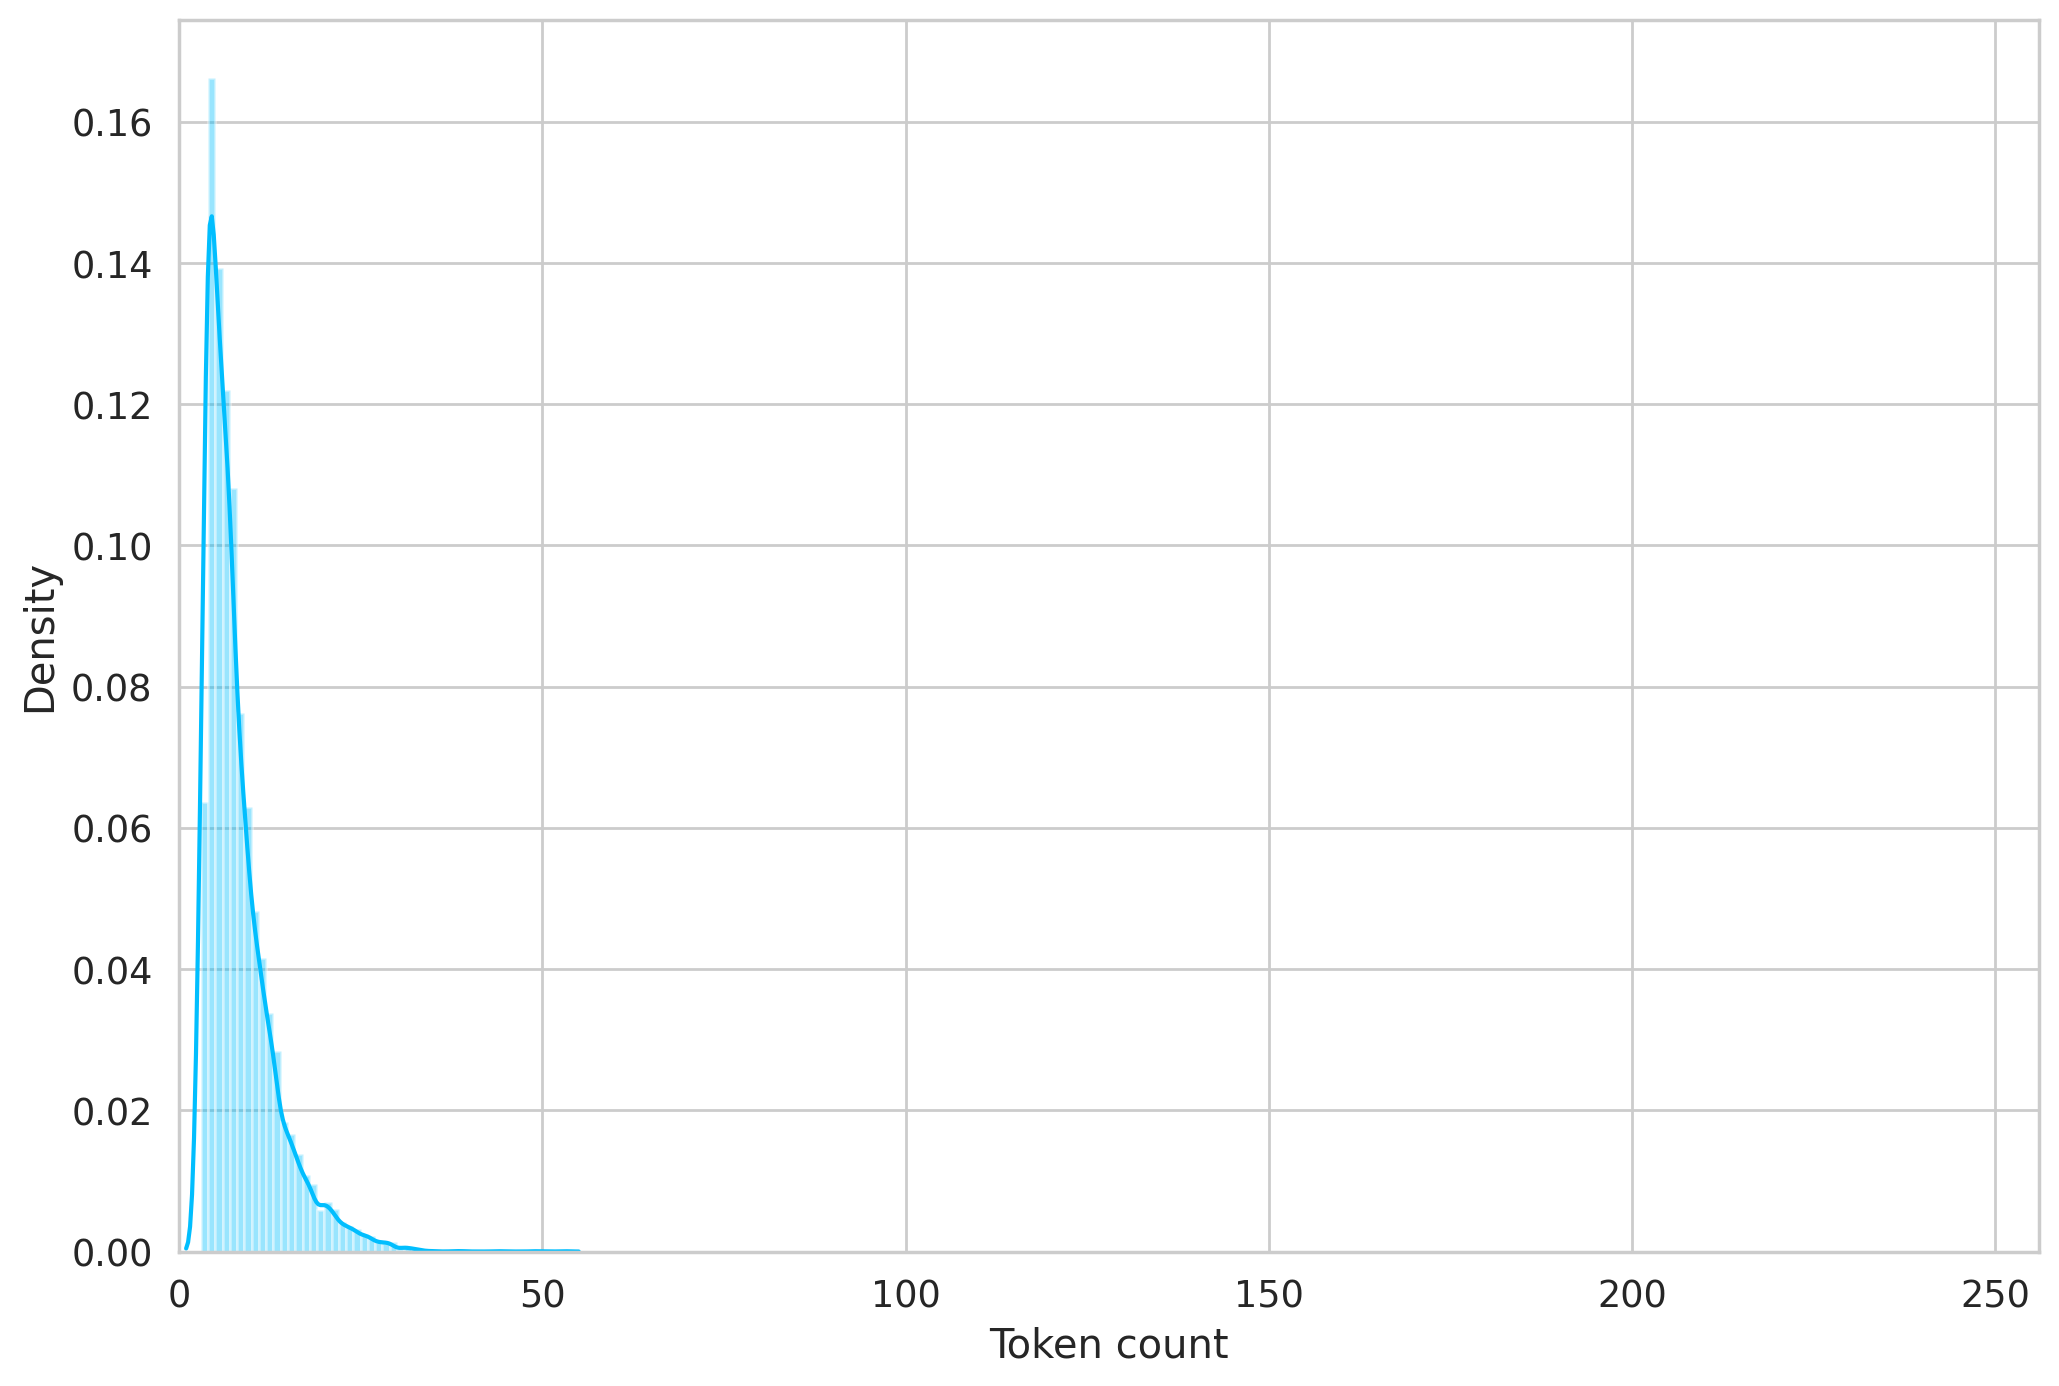

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 60

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    if target == 'negative':
       target = 0
    else:
       target = 1

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train = df[df.split=="train"]
df_val = df[df.split=="val"]
df_test = df[df.split=="test"]

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((12742, 3), (1592, 3), (1594, 3))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.rating.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    #num_workers=4 #  process hangs with num_workers=4
    num_workers=0,  #  num_workers: how many subprocesses to use for data loading. 0 means that the data will be 
                   #  loaded in the main process. (default: 0)
    shuffle=True   # , drop_last=True
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

## Sentiment Classification with BERT and Hugging Face

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs.pooler_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
        
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc.cpu().detach().numpy())
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc.cpu().detach().numpy())
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/MyDrive/Group assignment/text mining/BERT/rnn-transformer-sentiment/best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.5604670935854278 accuracy 0.7024799874431015
Val   loss 0.5142501163482666 accuracy 0.7418341708542714

Epoch 2/10
----------
Train loss 0.44219293465889187 accuracy 0.7793125098100768
Val   loss 0.5289443153142929 accuracy 0.7412060301507538

Epoch 3/10
----------
Train loss 0.3513263774694954 accuracy 0.8310312352848845
Val   loss 0.6177922576665879 accuracy 0.7349246231155779

Epoch 4/10
----------
Train loss 0.2883167394569942 accuracy 0.8645424580128708
Val   loss 0.7378387939929962 accuracy 0.7286432160804021

Epoch 5/10
----------
Train loss 0.2499496404707133 accuracy 0.8818081933762361
Val   loss 0.8319933450222016 accuracy 0.7317839195979899

Epoch 6/10
----------
Train loss 0.22686466973340302 accuracy 0.8953853398210642
Val   loss 0.9387801963090897 accuracy 0.7380653266331658

Epoch 7/10
----------
Train loss 0.2018903330537983 accuracy 0.9055878198085072
Val   loss 0.9744158837199212 accuracy 0.7305276381909548

Epoch 8/10
----------
Tra

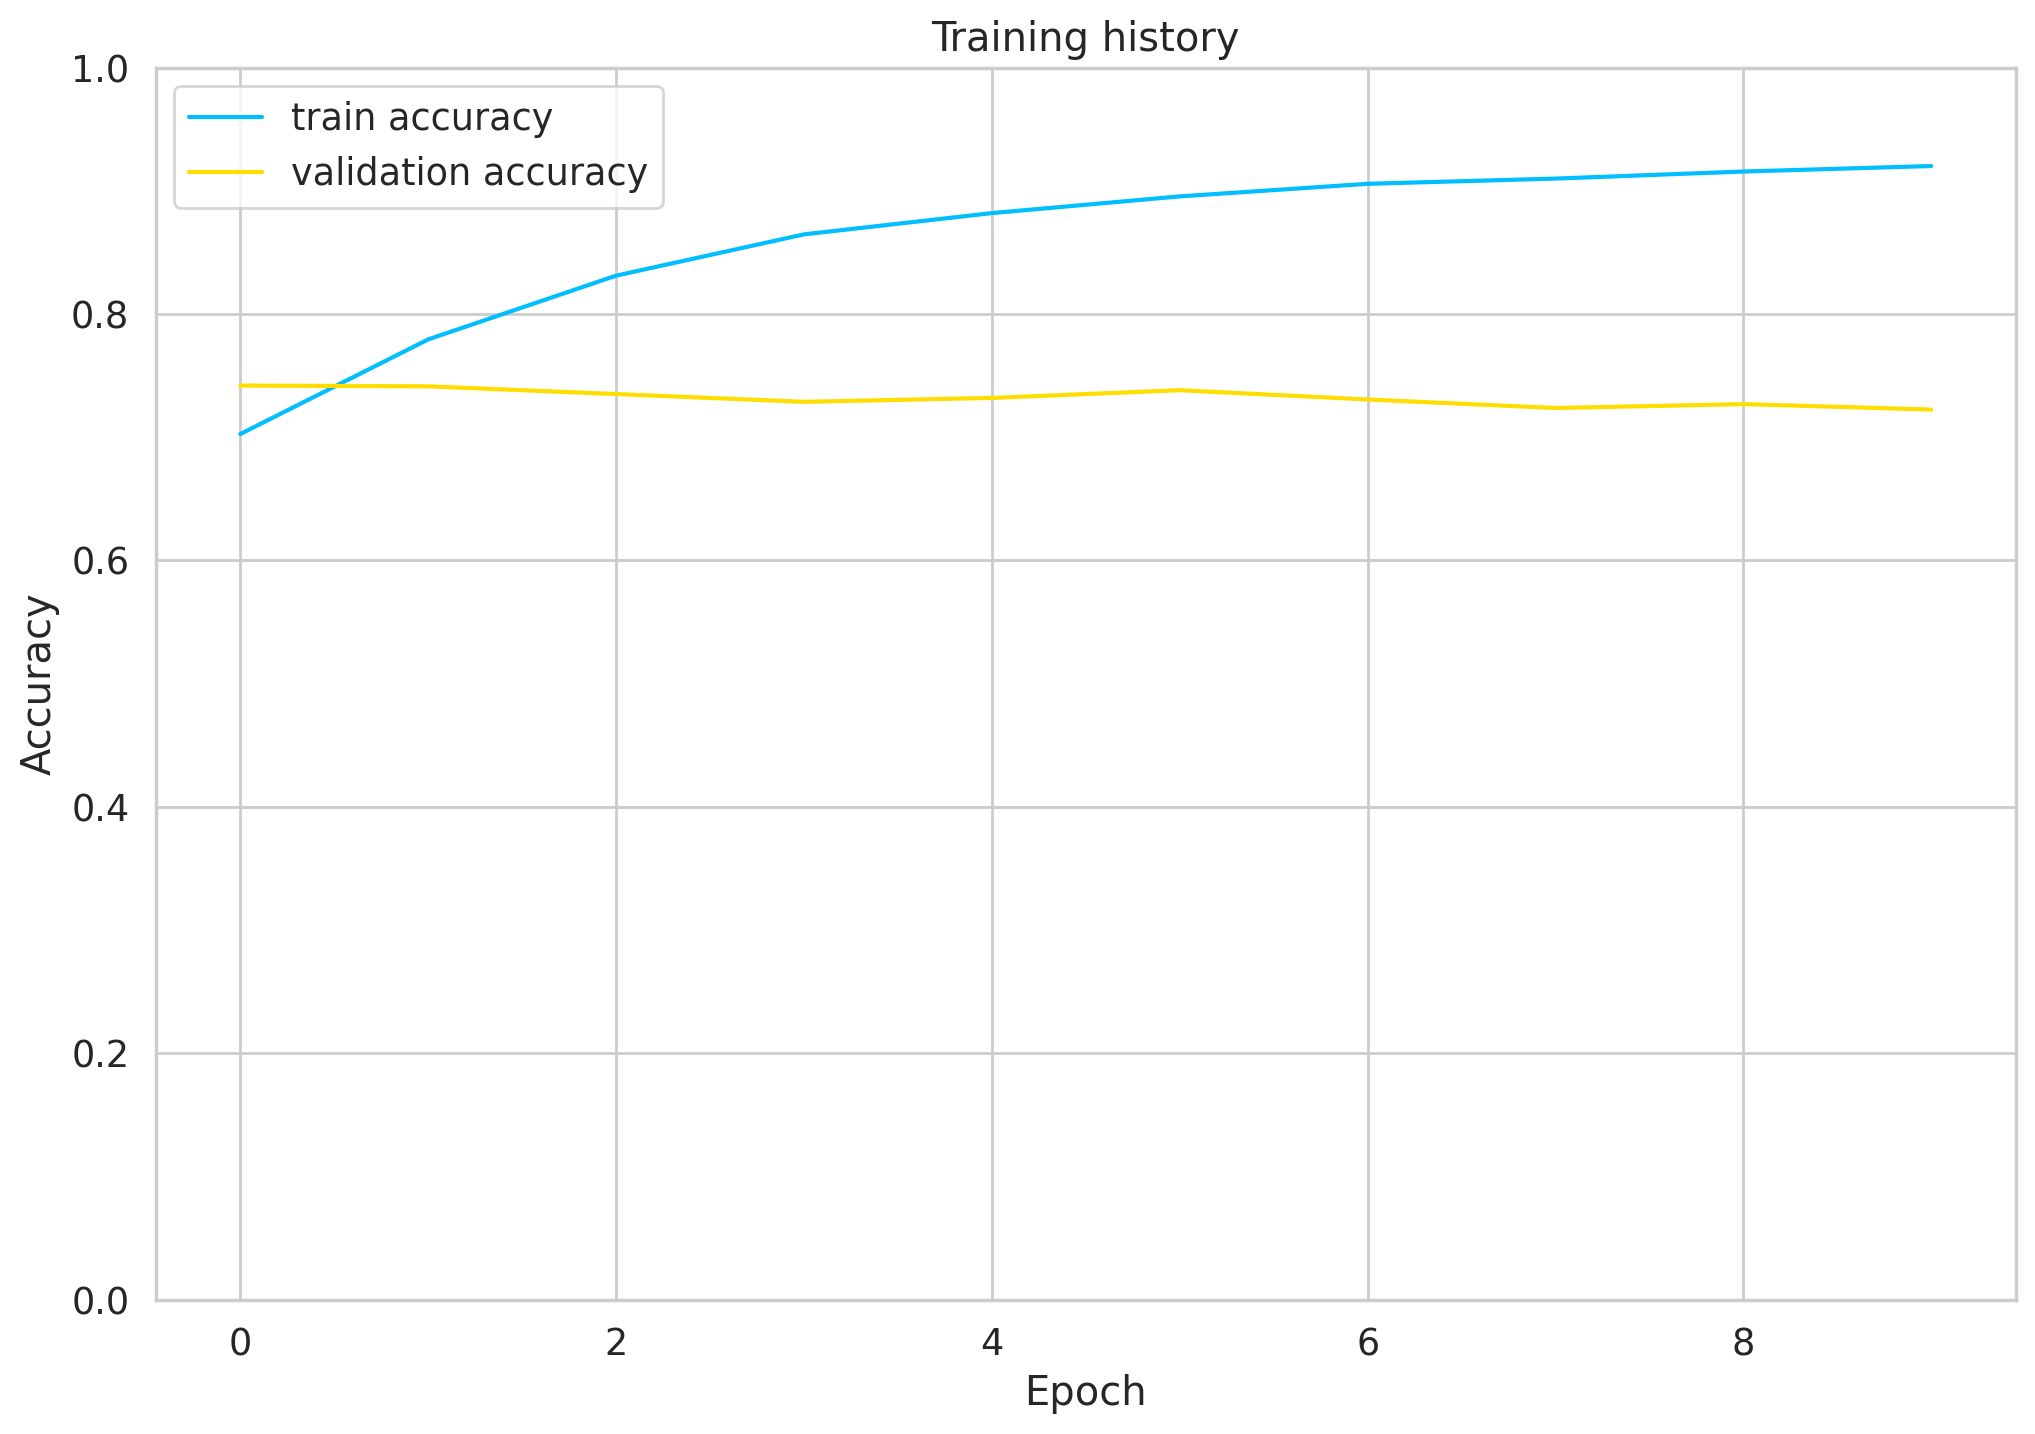

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Group assignment/text mining/BERT/rnn-transformer-sentiment/best_model_state.bin')) # load the best model
model = model.to(device) 

test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

test_acc.item(), test_loss.item()

(0.7327478042659974, 0.5105617612600326)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.75      0.74      0.74       830
    positive       0.72      0.73      0.72       764

    accuracy                           0.73      1594
   macro avg       0.73      0.73      0.73      1594
weighted avg       0.73      0.73      0.73      1594



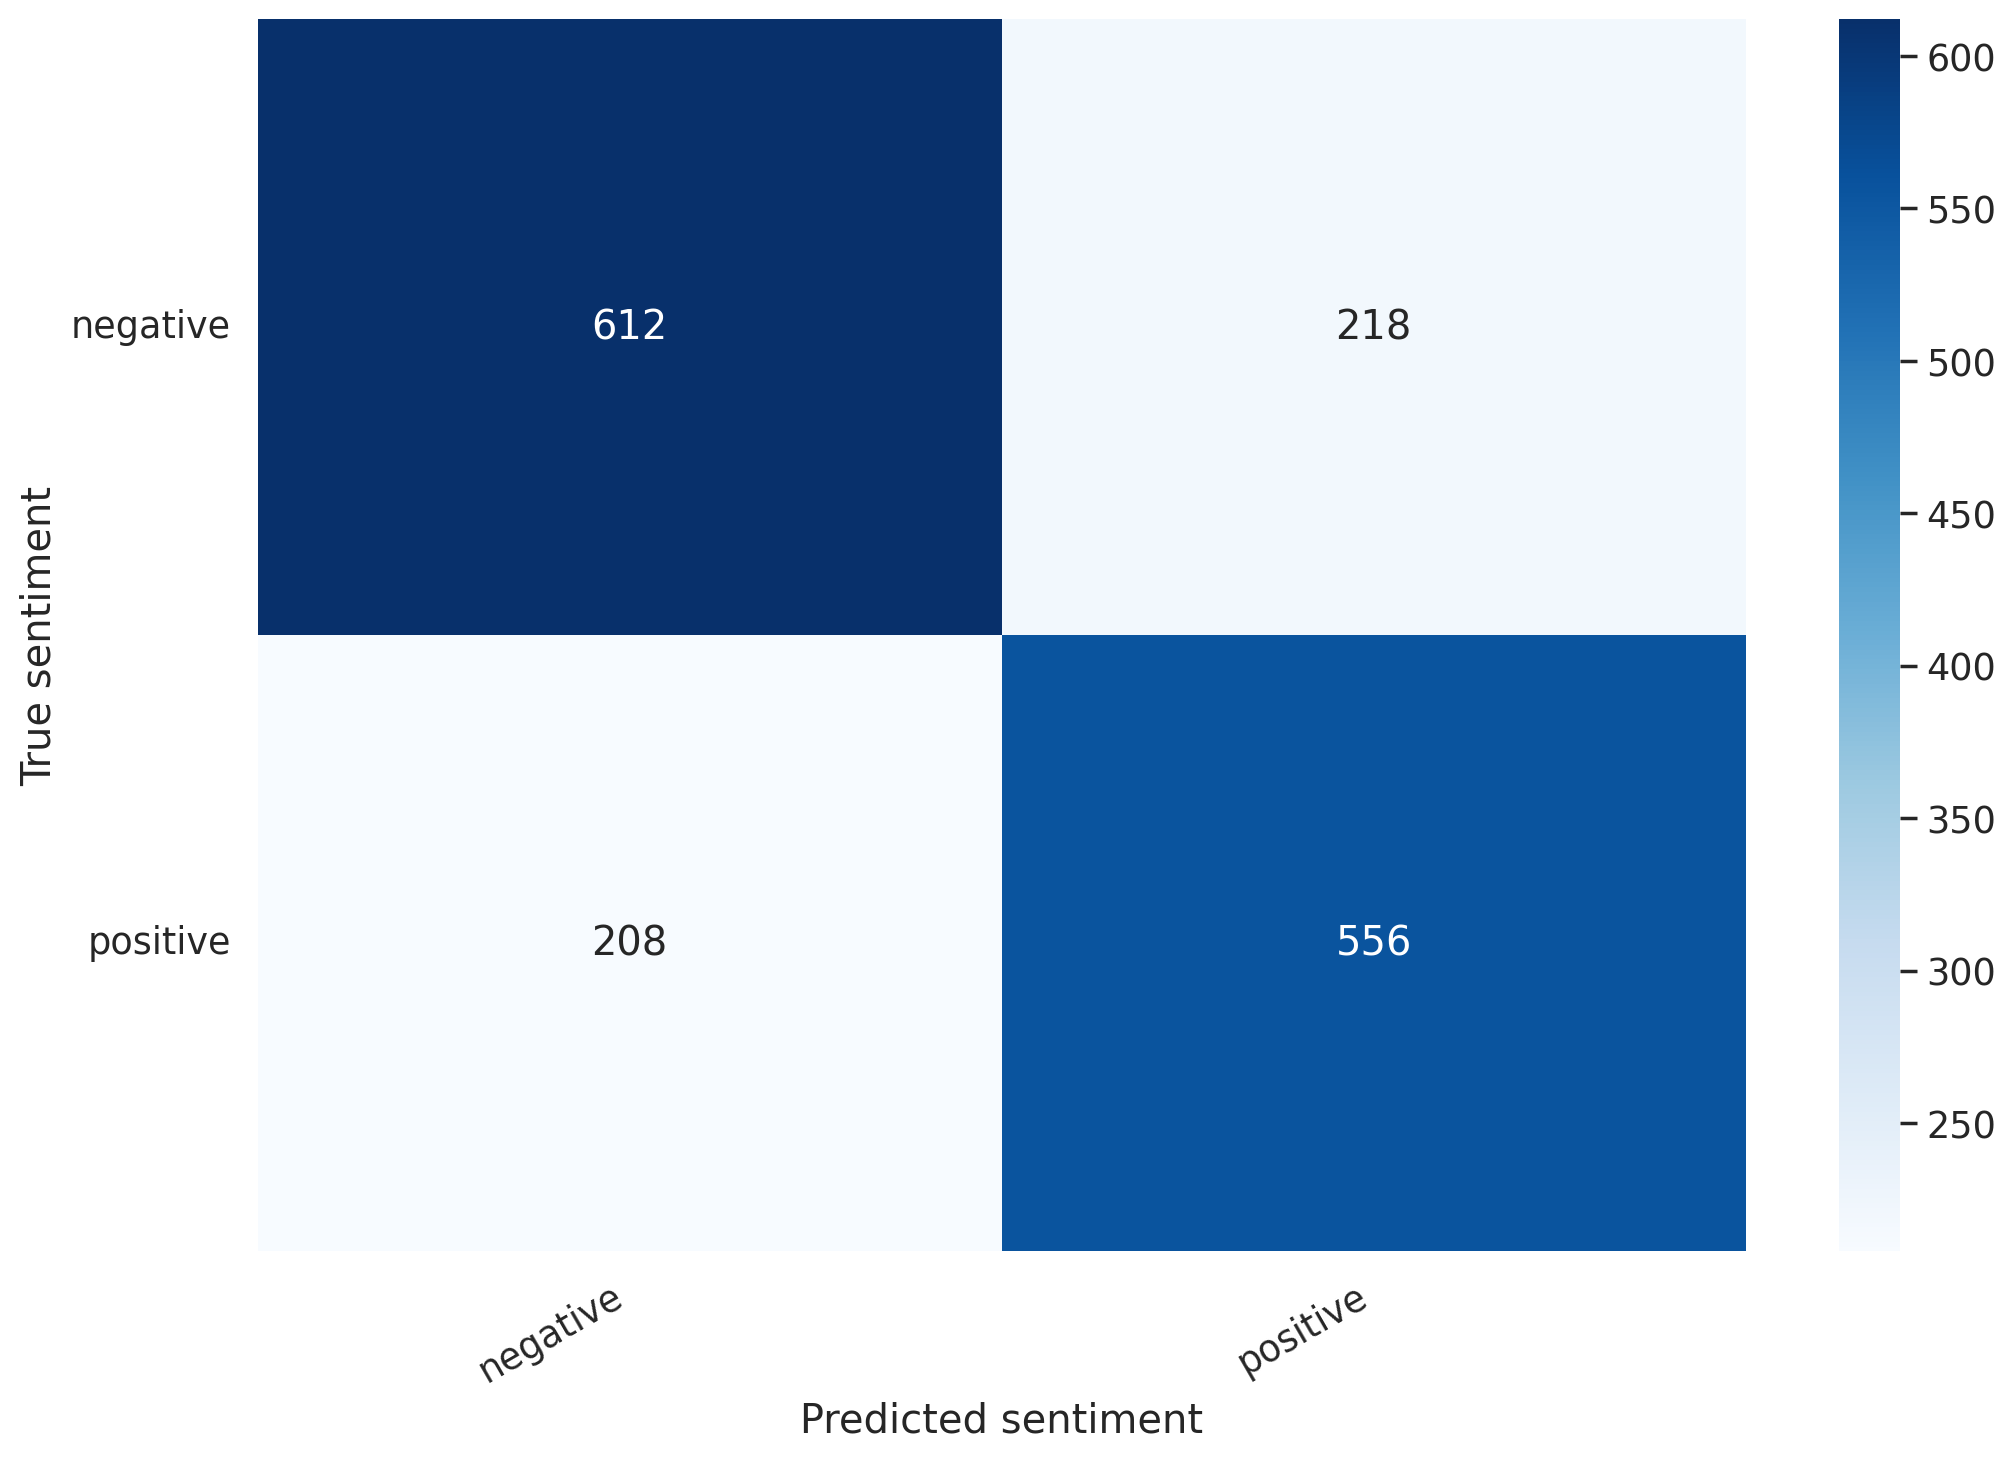

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 3

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Don't expect to go far...

True sentiment: negative


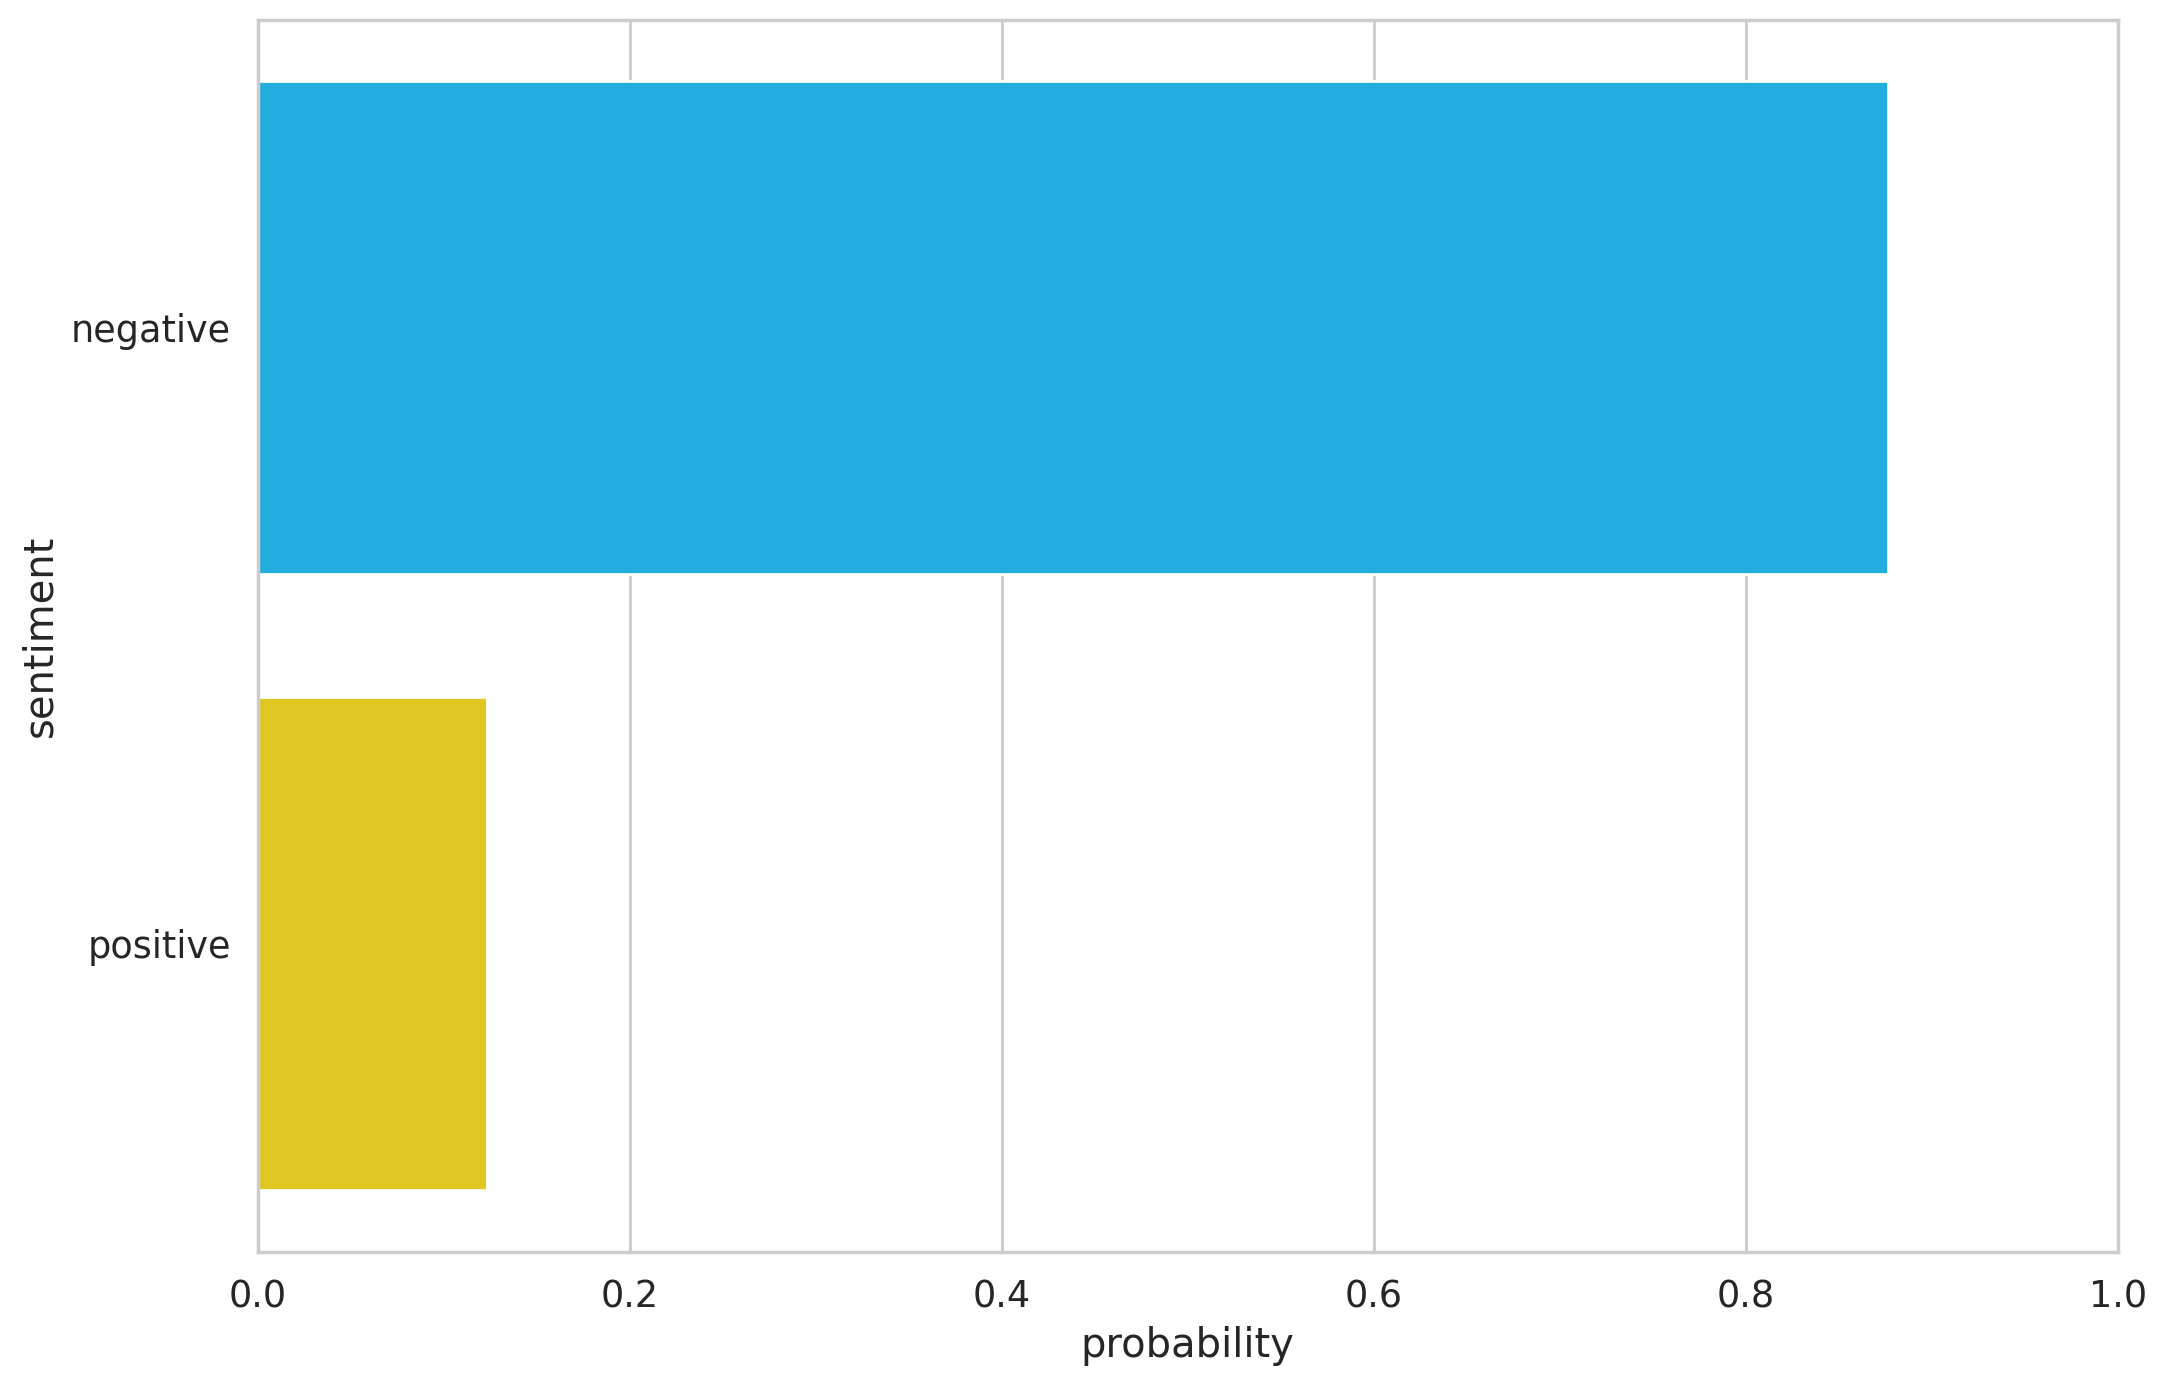

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text



In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
